In [1]:
from shared_DQN import IndependentDQN
from custom_spider_env.spider_fly_env.envs.grid_MA_testing import SpiderFlyEnvMA
from custom_spider_env.spider_fly_env.envs.pettingzoo_wrapper import PettingZooWrapper

import numpy as np

import pandas as pd

/home/hkolstee/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpiderFlyGrid-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/hkolstee/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpiderFlyGridMA-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


#### DQN (Shared parameters)

In [2]:
env = SpiderFlyEnvMA(render_mode = "ascii")
env = PettingZooWrapper(env)

env.observation_space[0].sample()

['X' 'O' ' ' ' ' ' ' 'O' 'X']


array([5, 6, 1, 2])

In [3]:
env = SpiderFlyEnvMA(max_steps = 200)
env = PettingZooWrapper(env)

In [4]:
IDQN = IndependentDQN(env, eps_steps = 50000, layer_sizes = (64, 64), tau = 0.0025, buffer_max_size = 50000) 

/home/hkolstee/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
rewards, losses = IDQN.train(1000)

Episode: 0 - Reward:[26 31] - Avg loss (last ep): [0.02203916 0.02079096]


KeyboardInterrupt: 

In [ ]:
data1 = np.vstack(rewards)
data2 = np.vstack(losses)

df1 = pd.DataFrame(data1, columns = ["agent_1", "agent_2"])
df1["Episode"] = list(range(data1.shape[0]))

df2 = pd.DataFrame(data2, columns = ["agent_1", "agent_2"])
df2["Episode"] = list(range(data1.shape[0]))

df1 = df1.melt('Episode', var_name='Agent', value_name='Rewards')
df2 = df2.melt('Episode', var_name='Agent', value_name='Rewards')

In [ ]:
# we need 1.5.0 for rolling average of next step
pd.__version__

'1.5.0'

In [ ]:
display(df1)
display(df2)

,Episode,Agent,Rewards
0,0,agent_1,36
1,1,agent_1,25
2,2,agent_1,39
3,3,agent_1,18
4,4,agent_1,23
...,...,...,...
1995,995,agent_2,110
1996,996,agent_2,107
1997,997,agent_2,113
1998,998,agent_2,126


,Episode,Agent,Rewards
0,0,agent_1,0.055967
1,1,agent_1,0.037010
2,2,agent_1,0.035359
3,3,agent_1,0.036384
4,4,agent_1,0.033635
...,...,...,...
1995,995,agent_2,0.068136
1996,996,agent_2,0.068481
1997,997,agent_2,0.066768
1998,998,agent_2,0.065600


In [ ]:
df1["Avg_Reward"] = df1["Rewards"].rolling(window = 5, step = 5).mean()
df1 = df1[df1.Episode > 5]
df1.dropna()

df2["Avg_Loss"] = df2["Rewards"].rolling(window = 5, step = 5).mean()
df2 = df2[df2.Episode > 5]
df2.dropna()

,Episode,Agent,Rewards,Avg_Loss
10,10,agent_1,0.035152,0.035508
15,15,agent_1,0.046284,0.041679
20,20,agent_1,0.049336,0.047908
25,25,agent_1,0.058299,0.055720
30,30,agent_1,0.053742,0.054235
...,...,...,...,...
1975,975,agent_2,0.065172,0.068041
1980,980,agent_2,0.068212,0.067710
1985,985,agent_2,0.068421,0.067348
1990,990,agent_2,0.067132,0.065895


<Axes: title={'center': 'Losses'}, xlabel='Episode', ylabel='Avg_Loss'>

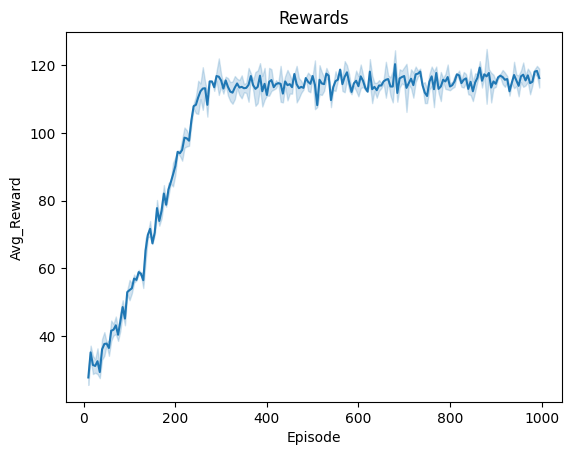

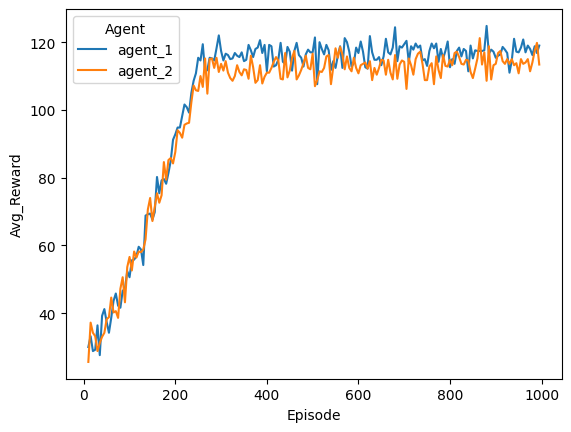

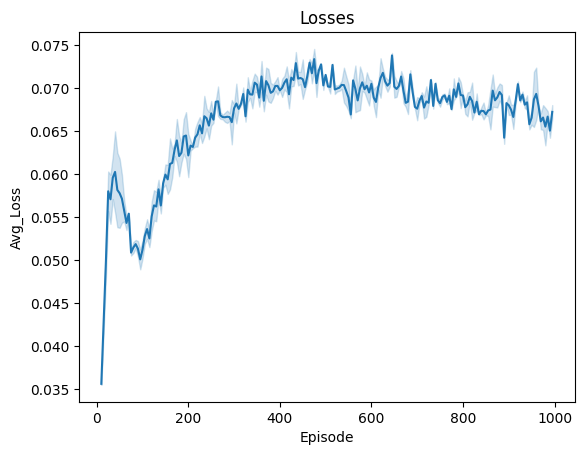

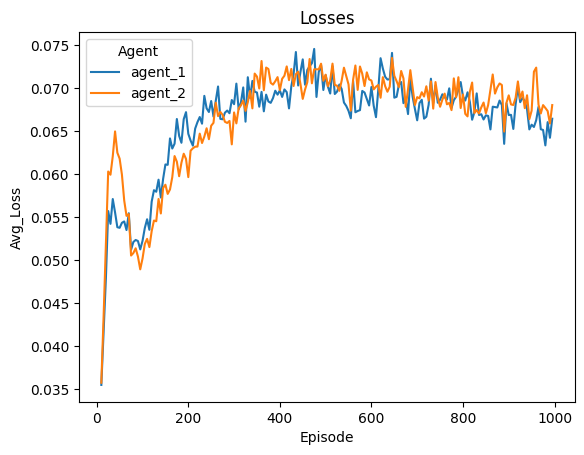

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.title("Rewards")
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward")
plt.title("Rewards")
plt.figure()
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward", hue = "Agent")

plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss")
plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss", hue = "Agent")

#### Sequential Q-learning

Tabular Q-learning:
$$
\begin{align*}
    & s = env.reset()\\
    &\text{while not } done:\\
    & \quad\quad \text{for } i \text{ in } (1, \ldots, m):\\
    & \quad\quad\quad\quad a_i = \argmax_{a_i} Q_i(s_i, a_i)\\
    & \quad\quad s', r, d = env.step(a_1, \ldots, a_m)\\
    & \quad\quad \text{for } i \text{ in } (1, \ldots, m):\\
    & \quad\quad\quad\quad Q_i(s, a_i) = Q_i(s, a_i) + lr * ((mean(r) + \gamma * \max_{a'_i} Q_i(s', a'_i)) - Q_i(s, a_i))\\
\end{align*}
$$


Sequential Tabular Q-learning:
$$
\begin{align*}
    & s = env.reset()\\
    &\text{while not } done:\\
    & \quad\quad \text{for } i \text{ in } (1, \ldots, m):\\
    & \quad\quad\quad\quad a_i = \argmax_{a_i} Q_i(s, a_1, \ldots, a_i)\\
    & \quad\quad s', r, d = env.step(a_1, \ldots, a_m)\\
    & \quad\quad \text{for } i \text{ in } (1, \ldots, m-1):\\
    & \quad\quad\quad\quad Q_i(s, a_1, \ldots, a_i) = Q_i(s, a_1, \ldots, a_i) + (i/m) * lr * (\max_{a_{i+1}} Q_{i+1}(s, a_1, \ldots, a_{i+1}) - Q_i(s, a_1, \ldots, a_i))\\
    & \quad\quad Q_m(s, a_1, \ldots, a_m) = Q_m(s, a_1, \ldots, a_m) + lr * ((mean(r) + \gamma * \max_{a'_1} Q_1(s', a'_1)) - Q_m(s, a_1, \ldots, a_m))\\
\end{align*}
$$

### Sequential DQN

In [1]:
from shared_seq_DQN import seqDQN

from shared_DQN import IndependentDQN
from custom_spider_env.spider_fly_env.envs.grid_MA_testing import SpiderFlyEnvMA
from custom_spider_env.spider_fly_env.envs.pettingzoo_wrapper import PettingZooWrapper

import numpy as np

import pandas as pd

2024-04-25 13:02:42.325431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'spider_fly_env.envs'

In [ ]:
env = SpiderFlyEnvMA(max_steps = 200)
env = PettingZooWrapper(env)

env.observation_space[0].sample()

array([3, 5, 2, 2])

In [ ]:
sequential_DQN = seqDQN(env, eps_steps = 50000, layer_sizes = (64, 64), tau = 0.0025, buffer_max_size = 50000, global_observations= True) 

In [ ]:
rewards, losses = sequential_DQN.train(1000)

Episode: 0 - Reward:[-0.473 -0.473 -0.473 -0.473] - Avg loss (last ep): [0. 0. 0. 0.]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/hkolstee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_17119/3186384670.py", line 1, in <module>
    rewards, losses = sequential_DQN.train(1000)
  File "/home/hkolstee/masterThesis/masterThesis/shared_seq_DQN.py", line 241, in train
  File "/home/hkolstee/masterThesis/masterThesis/shared_seq_DQN.py", line 174, in learn
RuntimeError: Class values must be smaller than num_classes.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hkolstee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2142, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/hkolstee/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(


In [2]:
data1 = np.vstack(rewards)
data2 = np.vstack(losses)

df1 = pd.DataFrame(data1, columns = ["agent_1", "agent_2"])
df1["Episode"] = list(range(data1.shape[0]))

df2 = pd.DataFrame(data2, columns = ["agent_1", "agent_2"])
df2["Episode"] = list(range(data1.shape[0]))

df1 = df1.melt('Episode', var_name='Agent', value_name='Rewards')
df2 = df2.melt('Episode', var_name='Agent', value_name='Rewards')

NameError: name 'np' is not defined

In [6]:
df1["Avg_Reward"] = df1["Rewards"].rolling(window = 5, step = 5).mean()
df1 = df1[df1.Episode > 5]
df1.dropna()

df2["Avg_Loss"] = df2["Rewards"].rolling(window = 5, step = 5).mean()
df2 = df2[df2.Episode > 5]
df2.dropna()

,Episode,Agent,Rewards,Avg_Loss
10,10,agent_1,0.009714,0.008082
15,15,agent_1,0.008295,0.008854
20,20,agent_1,0.010046,0.011249
25,25,agent_1,0.009716,0.012185
30,30,agent_1,0.012679,0.014364
...,...,...,...,...
1975,975,agent_2,0.025843,0.026006
1980,980,agent_2,0.026148,0.025934
1985,985,agent_2,0.026108,0.025805
1990,990,agent_2,0.025206,0.025501


<Axes: title={'center': 'Losses'}, xlabel='Episode', ylabel='Avg_Loss'>

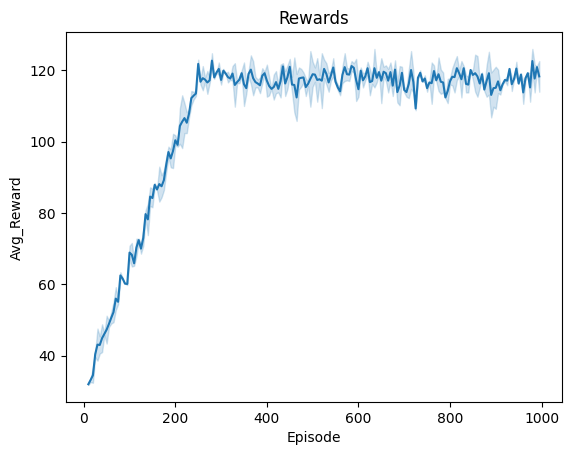

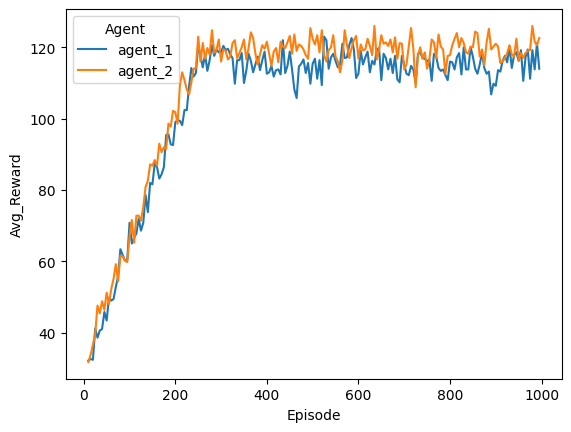

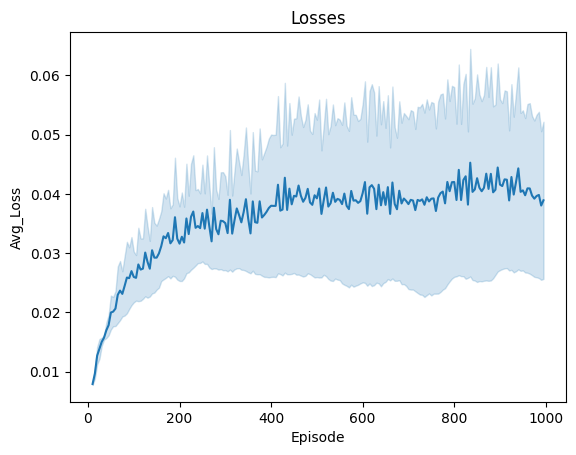

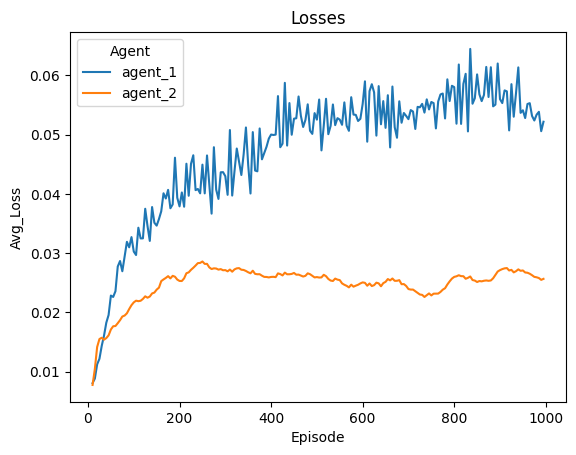

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.title("Rewards")
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward")
plt.title("Rewards")
plt.figure()
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward", hue = "Agent")

plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss")
plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss", hue = "Agent")

In [3]:
from shared_seq_DQN import seqDQN

from shared_DQN import IndependentDQN
from custom_spider_env.spider_fly_env.envs.grid_MA_testing import SpiderFlyEnvMA
from custom_spider_env.spider_fly_env.envs.pettingzoo_wrapper import PettingZooWrapper

import numpy as np

import pandas as pd

env = SpiderFlyEnvMA(max_steps = 200)
env = PettingZooWrapper(env)

env.observation_space[0].sample()
sequential_DQN = seqDQN(env, eps_steps = 200 * 30, gamma = 0.99, layer_sizes = (32, 32), tau = 0.0025, buffer_max_size = 5000, global_observations = True) 
rewards, losses = sequential_DQN.train(100)

Episode: 0 - Reward:[25 17] - Avg loss (last ep): [0. 0.]
Episode: 5 - Reward:[34 40] - Avg loss (last ep): [0.00303255 0.01485028]
Episode: 10 - Reward:[50 60] - Avg loss (last ep): [0.00925233 0.01911351]
Episode: 15 - Reward:[58 89] - Avg loss (last ep): [0.01188128 0.02132565]
Episode: 20 - Reward:[72 73] - Avg loss (last ep): [0.01578359 0.02344744]
Episode: 25 - Reward:[113 103] - Avg loss (last ep): [0.01262612 0.02427904]
Episode: 30 - Reward:[113 109] - Avg loss (last ep): [0.01578962 0.02311627]
Episode: 35 - Reward:[104 110] - Avg loss (last ep): [0.01733498 0.02289443]
Episode: 40 - Reward:[101 115] - Avg loss (last ep): [0.01590987 0.02286647]
Episode: 45 - Reward:[119 118] - Avg loss (last ep): [0.01789798 0.02277217]
Episode: 50 - Reward:[108 110] - Avg loss (last ep): [0.02728471 0.02232168]
Episode: 55 - Reward:[113 104] - Avg loss (last ep): [0.02651934 0.02189796]
Episode: 60 - Reward:[ 94 110] - Avg loss (last ep): [0.02218757 0.02139016]
Episode: 65 - Reward:[ 99 1

<Axes: title={'center': 'Losses'}, xlabel='Episode', ylabel='Avg_Loss'>

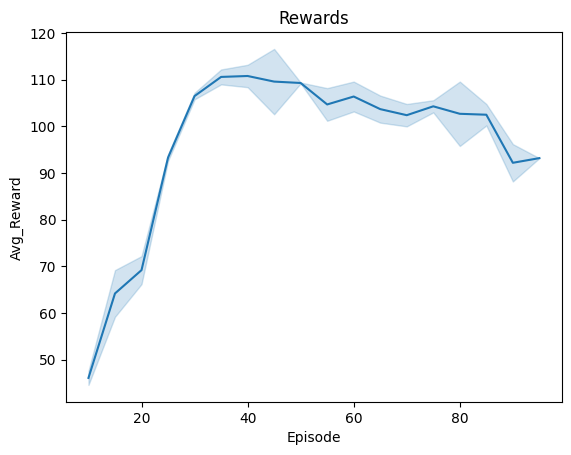

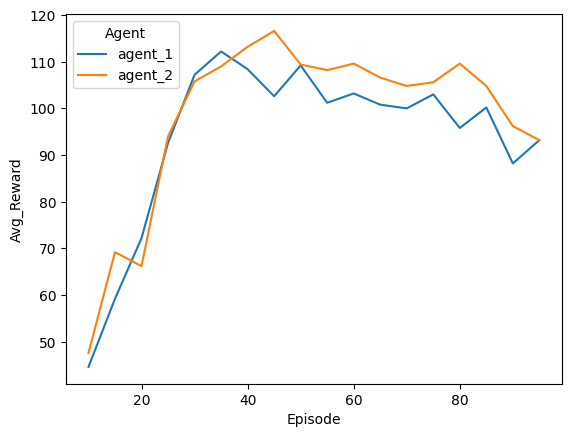

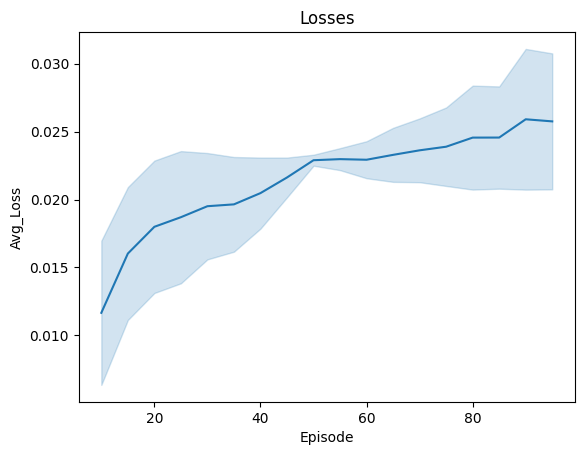

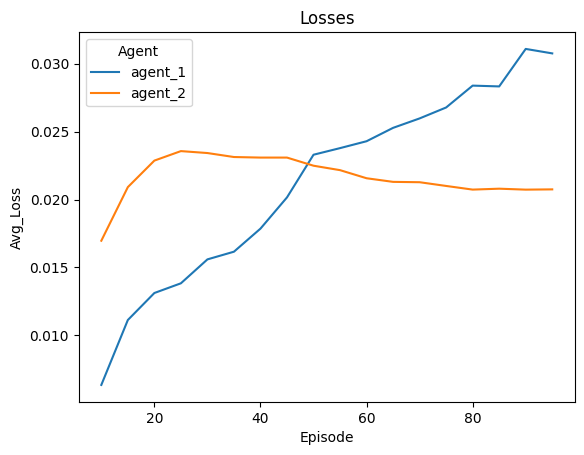

In [4]:
data1 = np.vstack(rewards)
data2 = np.vstack(losses)

df1 = pd.DataFrame(data1, columns = ["agent_1", "agent_2"])
df1["Episode"] = list(range(data1.shape[0]))

df2 = pd.DataFrame(data2, columns = ["agent_1", "agent_2"])
df2["Episode"] = list(range(data1.shape[0]))

df1 = df1.melt('Episode', var_name='Agent', value_name='Rewards')
df2 = df2.melt('Episode', var_name='Agent', value_name='Rewards')
df1["Avg_Reward"] = df1["Rewards"].rolling(window = 3, step = 3).mean()
df1 = df1[df1.Episode > 3]
df1.dropna()

df2["Avg_Loss"] = df2["Rewards"].rolling(window = 3, step = 3).mean()
df2 = df2[df2.Episode > 3]
df2.dropna()

import seaborn as sns
import matplotlib.pyplot as plt

plt.title("Rewards")
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward")
plt.title("Rewards")
plt.figure()
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward", hue = "Agent")

plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss")
plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss", hue = "Agent")

In [1]:
from shared_seq_DQN import seqDQN

from custom_spider_env.spider_fly_env.envs.grid_MA_pettingzoo import SpiderFlyEnvMA
from custom_spider_env.spider_fly_env.envs.pettingzoo_wrapper import PettingZooWrapper

import numpy as np

import pandas as pd

env = SpiderFlyEnvMA(4, 4, 1, 100, render_mode = "ascii")
env = PettingZooWrapper(env)

env = SpiderFlyEnvMA(4, 4, 1, 100)
env = PettingZooWrapper(env)

env.observation_space[0].sample()
sequential_DQN = seqDQN(env, eps_steps = 100 * 100, gamma = 0.995, layer_sizes = (64, 64), tau = 0.0025, buffer_max_size = 5000, global_observations = True) 
rewards, losses = sequential_DQN.train(500)

/home/hkolstee/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpiderFlyGrid-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/hkolstee/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpiderFlyGridMA-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'X']
 [' ' ' ' 'X' 'X']
 [' ' 'X' ' ' 'O']]


/home/hkolstee/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/hkolstee/masterThesis/masterThesis/shared_seq_DQN.py:316: RuntimeWarning: invalid value encountered in divide
  avg_loss = loss_sum / learn_steps
/home/hkolstee/masterThesis/masterThesis/shared_seq_DQN.py:318: RuntimeWarning: invalid value encountered in divide
  loss_log.append(loss_sum / learn_steps)


Episode: 0 - Reward:[0.998 0.988 0.994 0.986] - Avg loss (last ep): [nan nan nan nan]
Episode: 10 - Reward:[-0.084 -0.066 -0.076 -0.092] - Avg loss (last ep): [0.00064369 0.00038818 0.00023984 0.00064885]
Episode: 20 - Reward:[0.995 1.005 0.997 0.993] - Avg loss (last ep): [0.00031097 0.0003045  0.00014371 0.00051545]
Episode: 30 - Reward:[0.989 0.983 0.983 0.983] - Avg loss (last ep): [0.00033671 0.00028481 0.00016214 0.0006611 ]
Episode: 40 - Reward:[0.923 0.959 0.983 1.013] - Avg loss (last ep): [0.00040755 0.0003244  0.00020379 0.00095347]
Episode: 50 - Reward:[0.982 0.982 0.982 1.004] - Avg loss (last ep): [0.00050136 0.00029191 0.00021324 0.00080578]
Episode: 60 - Reward:[-0.011  0.001 -0.007 -0.011] - Avg loss (last ep): [0.00047368 0.00036011 0.0002438  0.00092808]
Episode: 70 - Reward:[-0.098  0.    -0.1   -0.026] - Avg loss (last ep): [0.00047542 0.00035174 0.00027697 0.00090936]
Episode: 80 - Reward:[0.998 0.956 0.964 0.952] - Avg loss (last ep): [0.00057361 0.00035674 0.000

KeyboardInterrupt: 

In [ ]:
terminal = False
obs, _ = env.reset()
while not terminal:
    actions = []
    actions = sequential_DQN.get_actions(obs, deterministic = True)

    obs, rewards, terminals, truncations, infos = env.step(actions)
    # print(actions)
    print(obs, rewards, terminals, truncations, infos, actions)
    print("--------------------")
    
    terminal = terminals[0]

In [4]:
data1 = np.vstack(rewards)
data2 = np.vstack(losses)

df1 = pd.DataFrame(data1, columns = ["agent_1", "agent_2", "agent_3", "agent_4"])
df1["Episode"] = list(range(data1.shape[0]))

df2 = pd.DataFrame(data2, columns = ["agent_1", "agent_2", "agent_3", "agent_4"])
df2["Episode"] = list(range(data1.shape[0]))

df1 = df1.melt('Episode', var_name='Agent', value_name='Rewards')
df2 = df2.melt('Episode', var_name='Agent', value_name='Rewards')
df1["Avg_Reward"] = df1["Rewards"].rolling(window = 5, step = 5).mean()
df1 = df1[df1.Episode > 5]
df1.dropna()

df2["Avg_Loss"] = df2["Rewards"].rolling(window = 5, step = 5).mean()
df2 = df2[df2.Episode > 5]
df2.dropna()

import seaborn as sns
import matplotlib.pyplot as plt

plt.title("Rewards")
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward")
plt.title("Rewards")
plt.figure()
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward", hue = "Agent")

plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss")
plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss", hue = "Agent")

[-0.003, -0.003, -0.003, -0.003]


ValueError: Shape of passed values is (4, 1), indices imply (4, 4)

In [4]:
from shared_seq_DQN import seqDQN

from shared_DQN import IndependentDQN
from custom_spider_env.spider_fly_env.envs.grid_MA_testing import SpiderFlyEnvMA
from custom_spider_env.spider_fly_env.envs.pettingzoo_wrapper import PettingZooWrapper

import numpy as np

import pandas as pd

In [3]:
env = SpiderFlyEnvMA(max_steps = 200)
env = PettingZooWrapper(env)

env.observation_space[0].sample()

array([4, 2, 1, 5])

In [10]:
sequential_DQN = seqDQN(env, eps_steps = 100 * 200, layer_sizes = (64, 64), tau = 0.0025, buffer_max_size = 50000) 

In [11]:
rewards, losses = sequential_DQN.train(300)

Episode: 0 - Reward:[34 17] - Avg loss (last ep): [0. 0.]


KeyboardInterrupt: 

In [ ]:
data1 = np.vstack(rewards)
data2 = np.vstack(losses)

df1 = pd.DataFrame(data1, columns = ["agent_1", "agent_2"])
df1["Episode"] = list(range(data1.shape[0]))

df2 = pd.DataFrame(data2, columns = ["agent_1", "agent_2"])
df2["Episode"] = list(range(data1.shape[0]))

df1 = df1.melt('Episode', var_name='Agent', value_name='Rewards')
df2 = df2.melt('Episode', var_name='Agent', value_name='Rewards')

In [ ]:
df1["Avg_Reward"] = df1["Rewards"].rolling(window = 5, step = 5).mean()
df1 = df1[df1.Episode > 5]
df1.dropna()

df2["Avg_Loss"] = df2["Rewards"].rolling(window = 5, step = 5).mean()
df2 = df2[df2.Episode > 5]
df2.dropna()

,Episode,Agent,Rewards,Avg_Loss
10,10,agent_1,0.009714,0.008082
15,15,agent_1,0.008295,0.008854
20,20,agent_1,0.010046,0.011249
25,25,agent_1,0.009716,0.012185
30,30,agent_1,0.012679,0.014364
...,...,...,...,...
1975,975,agent_2,0.025843,0.026006
1980,980,agent_2,0.026148,0.025934
1985,985,agent_2,0.026108,0.025805
1990,990,agent_2,0.025206,0.025501


<Axes: title={'center': 'Losses'}, xlabel='Episode', ylabel='Avg_Loss'>

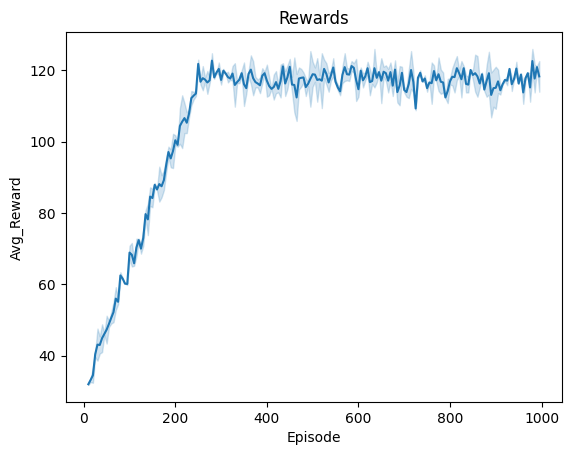

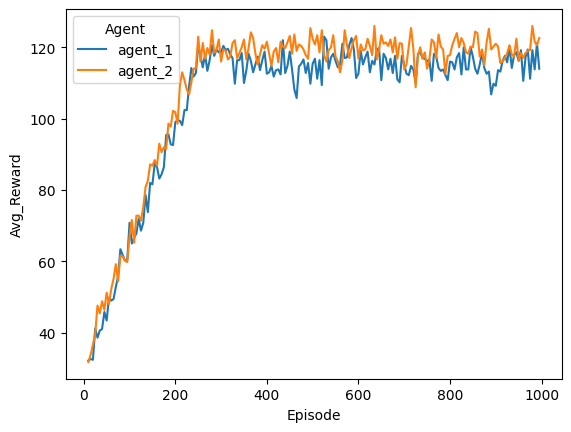

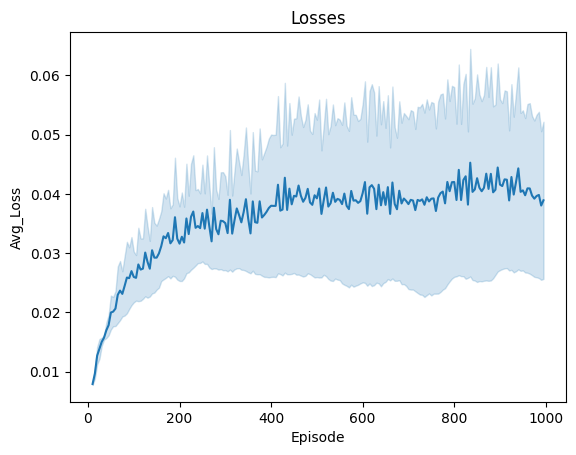

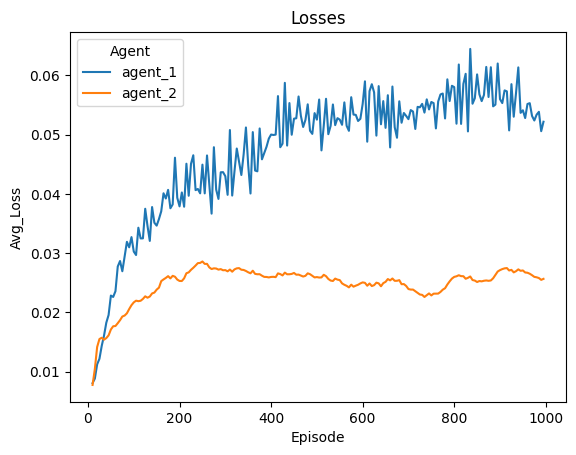

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.title("Rewards")
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward")
plt.title("Rewards")
plt.figure()
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward", hue = "Agent")

plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss")
plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss", hue = "Agent")

In [1]:
from shared_seq_double_DQN import seqDoubleDQN
from shared_seq_DQN import seqDQN
from shared_DQN import IndependentDQN
from custom_spider_env.spider_fly_env.envs.grid_MA_pettingzoo_easier import SpiderFlyEnvMA
from custom_spider_env.spider_fly_env.envs.pettingzoo_wrapper import PettingZooWrapper

import numpy as np

import pandas as pd

env = SpiderFlyEnvMA(size = 7, max_timesteps = 100, render_mode = "ascii")
env = PettingZooWrapper(env)

env.observation_space[0].sample()

env = SpiderFlyEnvMA(size = 7, max_timesteps = 100)
env = PettingZooWrapper(env)

# terminal = False
# obs, _ = env.reset()
# while not terminal:
#     actions = []
#     for act_space in env.action_space:
#         actions.append(act_space.sample())
    
#     obs, rewards, terminals, truncations, infos = env.step(actions)
#     # print(actions)
#     print(obs, rewards, terminals, truncations, infos, actions)
#     print("--------------------")
    
#     terminal = terminals[0]

/home/hkolstee/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpiderFlyGrid-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/hkolstee/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpiderFlyGridMA-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'O' ' ' 'X' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['X' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']]
[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['X' ' ' ' ' ' ' 'X' ' ' ' ']
 [' ' ' ' 'O' ' ' ' ' ' ' ' ']]
{'spider_0': 4, 'spider_1': 1}
[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'X' ' ' ' ' ' ']
 ['X' ' ' 'O' ' ' ' ' ' ' ' ']]
[[5, 3, 6, 0, 6, 2], [5, 3, 6, 0, 6, 2]] [-0.002, -0.002] [False, False] [False, False] [{}, {}] [4, 1]
--------------------
{'spider_0': 0, 'spider_1': 4}
[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' 

In [8]:
sequential_DQN = seqDQN(env, eps_steps = 100 * 200, layer_sizes = (64, 64), tau = 0.0025, buffer_max_size = 100000, batch_size = 8) 

rewards, losses = sequential_DQN.train(1000)

Episode: 0 - Reward:[-0.196 -0.196] - Avg loss (last ep): [0.00604549 0.00132558]
Episode: 50 - Reward:[0.964 0.964] - Avg loss (last ep): [0.00019517 0.00022857]
Episode: 100 - Reward:[-0.163 -0.163] - Avg loss (last ep): [0.00045354 0.00114687]
Episode: 150 - Reward:[-0.171 -0.171] - Avg loss (last ep): [0.00098357 0.0028852 ]
Episode: 200 - Reward:[-0.084 -0.084] - Avg loss (last ep): [0.00205213 0.00186631]
Episode: 250 - Reward:[-0.193 -0.193] - Avg loss (last ep): [0.00161994 0.00514154]
Episode: 300 - Reward:[-0.026 -0.026] - Avg loss (last ep): [0.00143095 0.00138185]
Episode: 350 - Reward:[0.97 0.97] - Avg loss (last ep): [0.0011343  0.00125123]
Episode: 400 - Reward:[-0.047 -0.047] - Avg loss (last ep): [0.00126235 0.00116503]
Episode: 450 - Reward:[0.989 0.989] - Avg loss (last ep): [0.00149391 0.01048033]
Episode: 500 - Reward:[-0.013 -0.013] - Avg loss (last ep): [0.00252651 0.00670546]
Episode: 550 - Reward:[0.985 0.985] - Avg loss (last ep): [0.00144979 0.00125324]
Episo

<Axes: title={'center': 'Losses'}, xlabel='Episode', ylabel='Avg_Loss'>

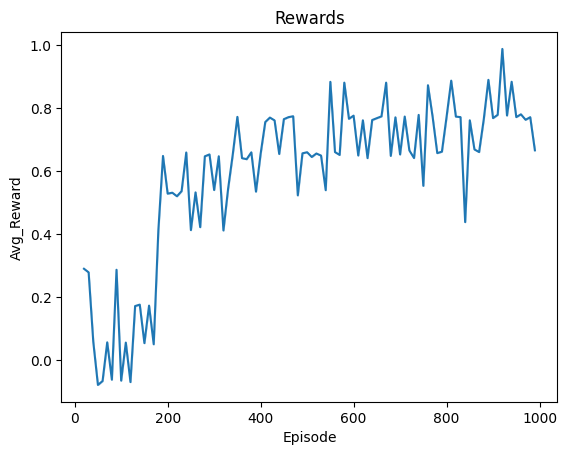

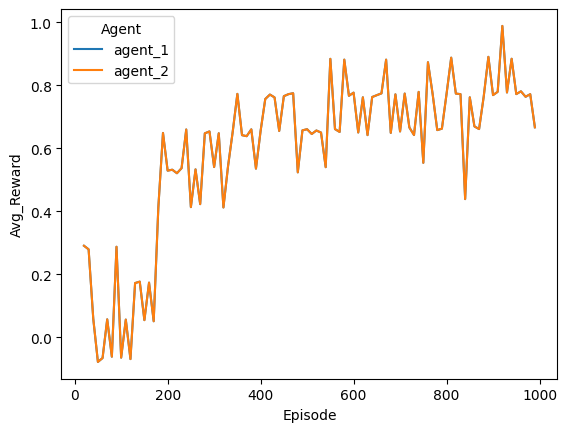

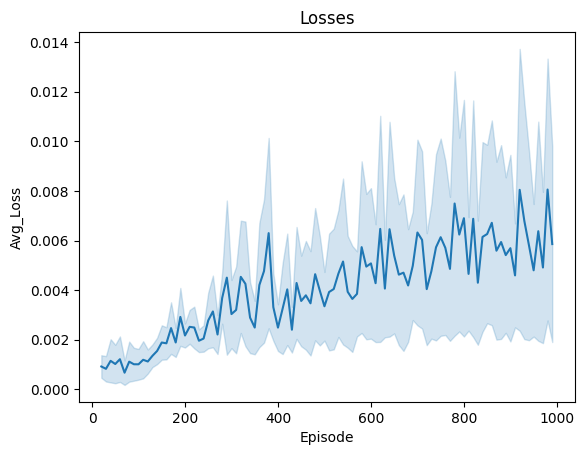

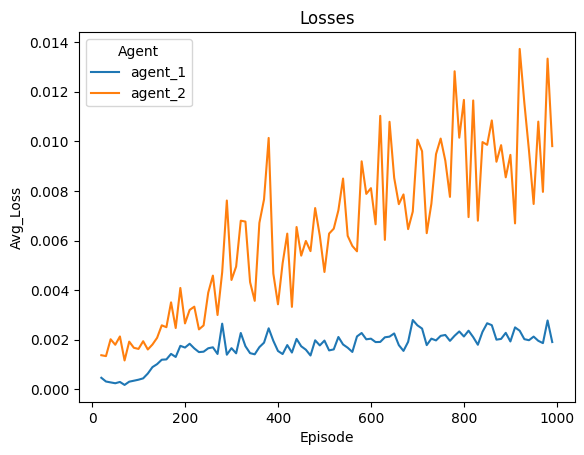

In [9]:

data1 = np.vstack(rewards)
data2 = np.vstack(losses)

df1 = pd.DataFrame(data1, columns = ["agent_1", "agent_2"])
df1["Episode"] = list(range(data1.shape[0]))

df2 = pd.DataFrame(data2, columns = ["agent_1", "agent_2"])
df2["Episode"] = list(range(data1.shape[0]))

df1 = df1.melt('Episode', var_name='Agent', value_name='Rewards')
df2 = df2.melt('Episode', var_name='Agent', value_name='Rewards')
df1["Avg_Reward"] = df1["Rewards"].rolling(window = 10, step = 10).mean()
df1 = df1[df1.Episode > 10]
df1.dropna()

df2["Avg_Loss"] = df2["Rewards"].rolling(window = 10, step = 10).mean()
df2 = df2[df2.Episode > 10]
df2.dropna()

import seaborn as sns
import matplotlib.pyplot as plt

plt.title("Rewards")
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward")
plt.title("Rewards")
plt.figure()
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward", hue = "Agent")

plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss")
plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss", hue = "Agent")

In [1]:
from shared_seq_double_DQN import seqDoubleDQN
from shared_seq_DQN import seqDQN
from shared_DQN import IndependentDQN
from custom_spider_env.spider_fly_env.envs.grid_MA_pettingzoo import SpiderFlyEnvMA
from custom_spider_env.spider_fly_env.envs.pettingzoo_wrapper import PettingZooWrapper

import numpy as np

import pandas as pd

env = SpiderFlyEnvMA(size = 4, max_timesteps = 100, render_mode = "ascii")
env = PettingZooWrapper(env)

env.observation_space[0].sample()

env = SpiderFlyEnvMA(size = 4, max_timesteps = 100)
env = PettingZooWrapper(env)


/home/hkolstee/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpiderFlyGrid-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/hkolstee/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpiderFlyGridMA-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


[['X' 'X' ' ' 'X']
 [' ' 'O' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'X' ' ' ' ']]


In [5]:
sequential_DQN = seqDQN(env, eps_steps = 100 * 1000, layer_sizes = (64, 64), tau = 0.0025, buffer_max_size = 100000, batch_size = 256) 

rewards, losses = sequential_DQN.train(2000)

/home/hkolstee/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/hkolstee/masterThesis/masterThesis/shared_seq_DQN.py:302: RuntimeWarning: invalid value encountered in divide
  loss_log.append(loss_sum / learn_steps)


Episode: 0 - Reward:[-0.281 -0.281 -0.281 -0.281] - Avg loss (last ep): [nan nan nan nan]


KeyboardInterrupt: 

<Axes: title={'center': 'Losses'}, xlabel='Episode', ylabel='Avg_Loss'>

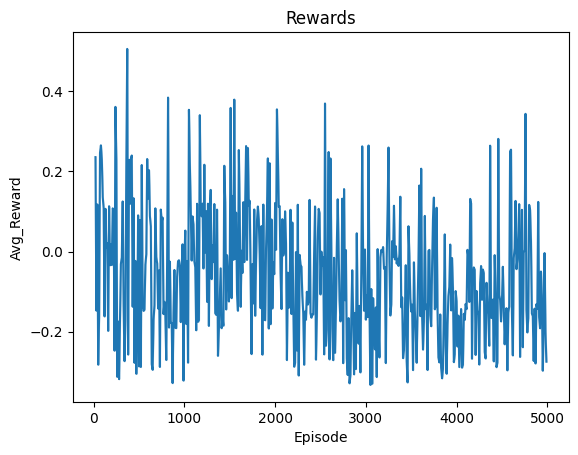

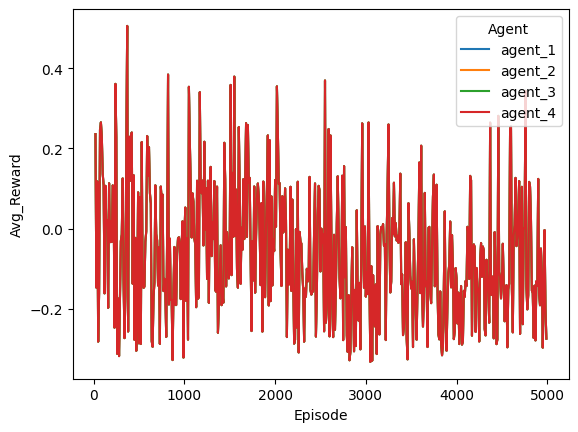

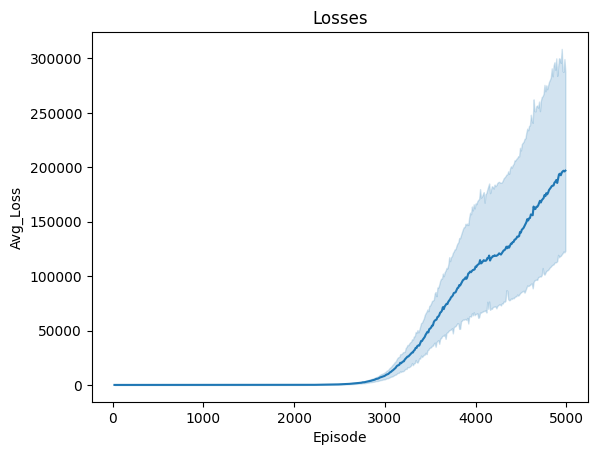

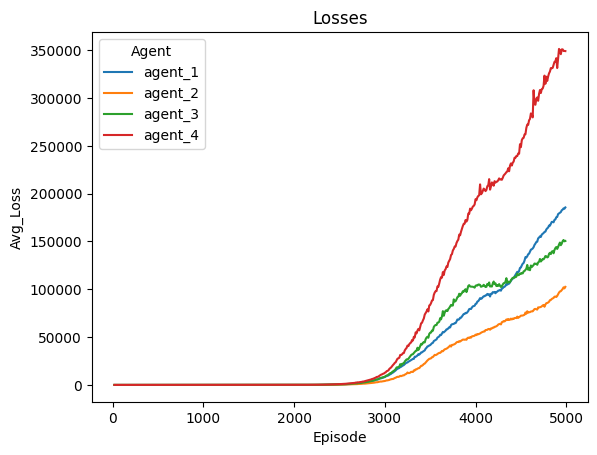

In [3]:

data1 = np.vstack(rewards)
data2 = np.vstack(losses)

df1 = pd.DataFrame(data1, columns = ["agent_1", "agent_2", "agent_3", "agent_4"])
df1["Episode"] = list(range(data1.shape[0]))

df2 = pd.DataFrame(data2, columns = ["agent_1", "agent_2", "agent_3", "agent_4"])
df2["Episode"] = list(range(data1.shape[0]))

df1 = df1.melt('Episode', var_name='Agent', value_name='Rewards')
df2 = df2.melt('Episode', var_name='Agent', value_name='Rewards')
df1["Avg_Reward"] = df1["Rewards"].rolling(window = 10, step = 10).mean()
df1 = df1[df1.Episode > 10]
df1.dropna()

df2["Avg_Loss"] = df2["Rewards"].rolling(window = 10, step = 10).mean()
df2 = df2[df2.Episode > 10]
df2.dropna()

import seaborn as sns
import matplotlib.pyplot as plt

plt.title("Rewards")
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward")
plt.title("Rewards")
plt.figure()
sns.lineplot(data = df1, x = "Episode", y = "Avg_Reward", hue = "Agent")

plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss")
plt.figure()
plt.title("Losses")
sns.lineplot(data = df2, x = "Episode", y = "Avg_Loss", hue = "Agent")